# Prueba comparador de estrategias

In [1]:
%matplotlib inline

import datetime
import pandas as pd
import sys

sys.path.append(r'../2_avisos_cambio_fondos')
sys.path.append(r'../3_simulador')

from estrategias import Estrategia
from valores_cuota import df_valores_cuota

from comparador import agrega_estrategias

# PARAMETROS PARA DEFINIR LA ESTRATEGIA
fecha_ini = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d').date()
fecha_end = datetime.datetime.strptime('2020-11-23', '%Y-%m-%d').date()


estrategia_ff = Estrategia(fecha_ini, fecha_end, 'FF', 'anuncios_ff.xlsx')
estrategia_a = Estrategia(fecha_ini, fecha_end, 'A')

# El archivo "optima_HABITAT" se puede crear con código en "data_auxiliar/crea_estrategia_optima.py"
estrategia_optima = Estrategia(fecha_ini, fecha_end, 'MAX', 'optima_HABITAT.xlsx')

lista_estrategias = [estrategia_ff, estrategia_a, estrategia_optima]

afp = 'HABITAT'
monto_inicial = 100
lag_solicitud = 0

df = agrega_estrategias(lista_estrategias, afp, monto_inicial, lag_solicitud)
df

,Fecha,Val_FF_lag_0,Val_A_lag_0,Val_MAX_lag_0
0,2014-01-01,100.000000,100.000000,100.000000
1,2014-01-02,100.336932,100.336932,100.033161
2,2014-01-03,100.253135,100.253135,100.009698
3,2014-01-04,100.253135,100.253135,100.009698
4,2014-01-05,100.253135,100.253135,100.009698
...,...,...,...,...
2514,2020-11-19,168.894963,181.489112,435.675146
2515,2020-11-20,168.880442,181.551498,435.824908
2516,2020-11-21,168.880442,181.551498,435.824908
2517,2020-11-22,168.880442,181.551498,435.824908


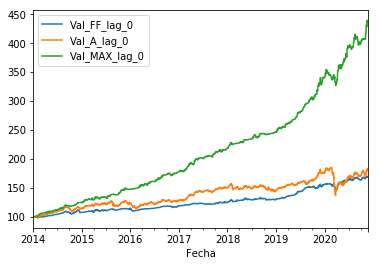

In [2]:
df.set_index('Fecha').plot()

In [3]:
estrategia_optima

Estrategia: MAX
Fecha Inicio: 2014-01-01
Fecha Término: 2020-11-23

2014-01-01 - 2014-01-31 : [0, 0, 0, 0, 1.0]
2014-01-31 - 2014-02-28 : [1.0, 0, 0, 0, 0]
2014-02-28 - 2014-03-31 : [0, 0, 0, 0, 1.0]
...
2020-10-31 - 2020-11-23 : [1.0, 0, 0, 0, 0]